In [5]:
import h5py
import numpy as np
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.style.use('classic')
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess

from scipy.interpolate import RectBivariateSpline, interp2d
from scipy.ndimage import map_coordinates

import utils

In [13]:
py_directory = "../"
py_directory += "output_travelling_vortex/"

def spatially_averaged_rmse(arr,ref):
    arr = arr[2:-2,2:-2]
    ref = ref[2:-2,2:-2]
    
    arr -= arr.mean()
    ref -= ref.mean()
    
    n,m = ref.shape
    N = n * m
    return np.sqrt(((arr - ref)**2).mean())

def get_filename(grid_x,grid_y,size,end_time,suffix):
    return "output_travelling_vortex_ensemble=" + str(size) + "_" + str(grid_x) + "_" + str(grid_y) + "_" + str(end_time) + suffix + ".h5"

def get_path(filename):
    return py_directory + filename

def py_out(pyfile,py_dataset,time):
    return pyfile[str(py_dataset)][str(py_dataset)+time][:]

def ensemble_test_case(time, path, N, attribute, label_type='TIME', tag='after_full_step'):
#     inner = (slice(2,-2),slice(2,-2))
    inner = (slice(None,),slice(None,))
    file = h5py.File(path,'r')

    array = []
    for n in range(N):
        if label_type == 'TIME':
#             if N==1:
#                 t_label = '_%.2f_after_full_step' %(time)
#             else:
            t_label = '_ensemble_mem=%i_%.3f_%s' %(n,time, tag)
        elif label_type == 'STEP':
            if N==1:
                t_label = '_%.3d_%s' %(time, tag)
            else:
                t_label = '_ensemble_mem=%i_%.3d_%s' %(n,time, tag)
            
        array.append(py_out(file,attribute,time=t_label)[inner])

    array = np.array(array)
    array = array.mean(axis=0)

    file.close()
    file.close()
    return np.array(array)

def bin_func(obs,ens_mem_shape):
    obs = obs.reshape(ens_mem_shape[0],obs.shape[0]//ens_mem_shape[0],
                      ens_mem_shape[1],obs.shape[1]//ens_mem_shape[1])
    return obs.mean(axis=(1,3))

def rmse(diff):
    return np.sqrt((diff**2).mean())

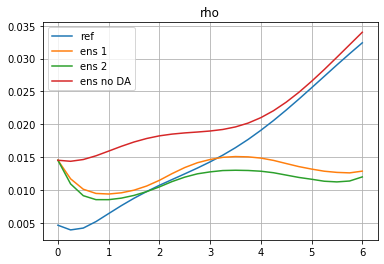

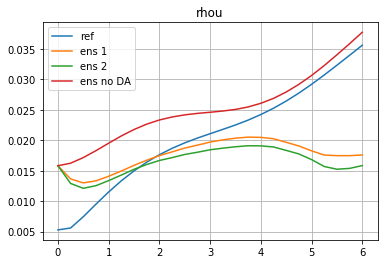

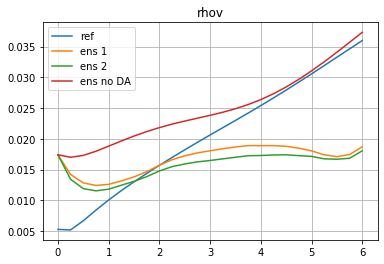

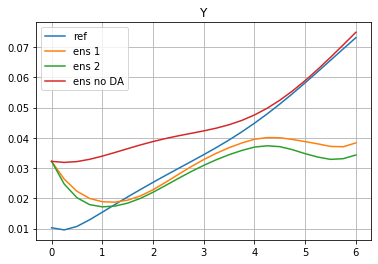

In [114]:
from importlib import reload
import utils
utils = reload(utils)

import plotting_tools as pt
pt = reload(pt)

times = np.arange(0.0,6.01,0.25)
base_fn = "output_travelling_vortex"
py_directory = "../%s/" %base_fn
attributes = ['rho','rhou','rhov','Y']

Nx = 32
Ny = 32
et = 6.0
# p_ref = 8.61 * 1e4

import scipy.ndimage as sciim

tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)
for attribute in attributes:
    
    ref = []
    ref_suffix = 'comp_pp_ref'
    ref.append(tc.get_ensemble(times, 1, attribute, ref_suffix, label_type='TIME'))
    
    ens_noda = []
#     ens_suffix = 'comp_pp_rhos_localised'
    ens_suffix = 'comp_pp_noda'
    ens_noda.append(tc.get_ensemble(times, 10, attribute, ens_suffix, label_type='TIME'))
    
    ens_1 = []
#     ens_suffix = 'comp'
    ens_suffix = 'comp'
    ens_suffix = 'comp_rloc'
    ens_1.append(tc.get_ensemble(times, 10, attribute, ens_suffix, label_type='TIME'))

    ens_2 = []
    ens_suffix = 'comp_rloc_localisation'
    ens_2.append(tc.get_ensemble(times, 10, attribute, ens_suffix, label_type='TIME'))

    
    truth = []
    truth.append(tc.get_ensemble(times, 1, attribute, 'truthgen', label_type='TIME'))
    
#     if attribute == 'rhov':
#         ens_testp = [[c,t] for c,t in zip(ens_1[0][::2] - truth[0][::2],times[::2])]
#         petp = pt.plotter(ens_testp)
#         petp.plot(figsize=(12,10))

    diff_ens_1 = tc.spatially_averaged_rmse(ens_1[0],truth[0])
    diff_ens_2 = tc.spatially_averaged_rmse(ens_2[0],truth[0])
    diff_noda = tc.spatially_averaged_rmse(ens_noda[0],truth[0])
    diff_ref = tc.spatially_averaged_rmse(ref[0],truth[0])
#     diff3 = tc.spatially_averaged_rmse(cb1[0],psinc[0])

    plt.figure()
    plt.plot(times,diff_ref, label='ref')
    plt.plot(times,diff_ens_1, label='ens 1')
    plt.plot(times,diff_ens_2, label='ens 2')
    plt.plot(times,diff_noda, label='ens no DA')
    plt.title("%s" %attribute)
    plt.grid()
    plt.legend()
    plt.show()

output_travelling_vortex_ensemble=10_32_32_6.0_comp.h5


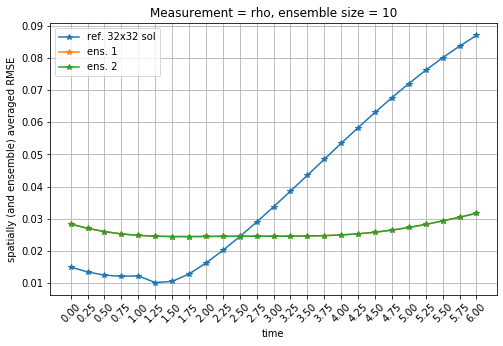

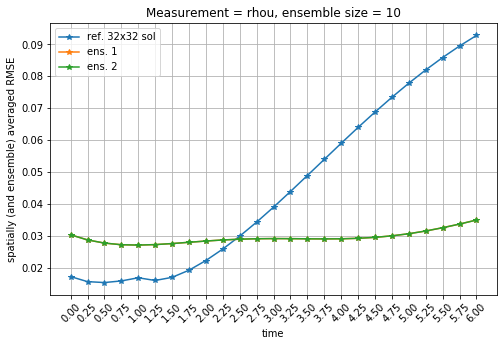

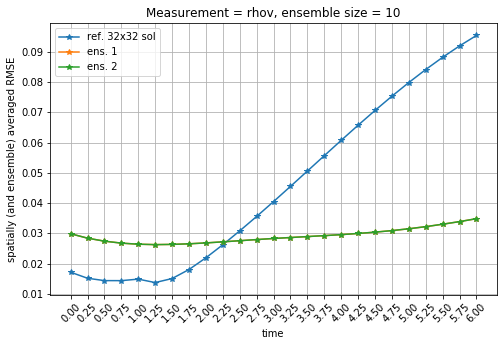

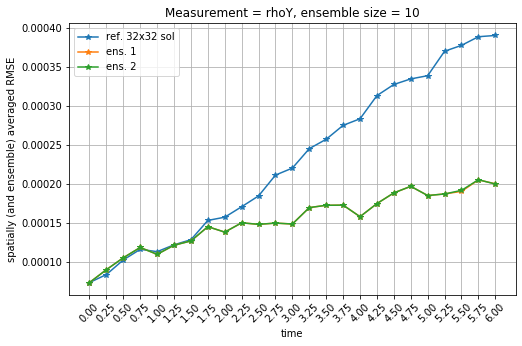

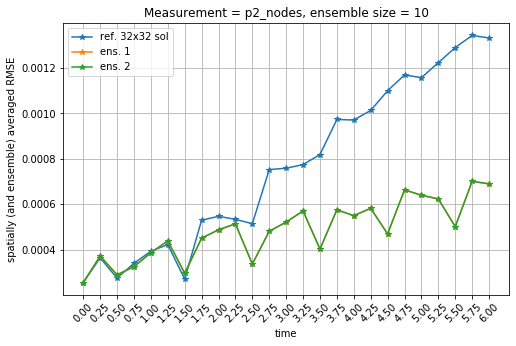

In [23]:
ref_grid_x = 32
ref_grid_y = 32
grid_x = 32
grid_y = 32
ref_size = 1
ens_size_1 = 10
ens_size_2 = 10
end_time = 6.0
print_output = True
print_diffs = True
ens_2 = True

# inner = (slice(2,-2),slice(2,-2))
# inner = (slice(None,),slice(None,))
slc = (slice(2,-2),slice(2,-2))
# slc = (slice(None,),slice(None,))

times = np.arange(0.0,6.1,0.25)

cb1 = [20,20]

attributes = ['rho', 'rhou', 'rhov', 'rhoY', 'p2_nodes']
# attributes = ['rhoY']
# attributes = ['p2_nodes']
fn_suffix = ""

# ens_1_suffix = '_comp_fmp_rhoY_noconv'
ens_1_suffix = '_cont_blend_fs=1_ts=0'
ens_1_suffix = '_comp'

ens_2_suffix = '_comp_noda_pp'
ens_2_suffix = '_comp_fmp_rhoY_noconv'

py_filename_ref = get_filename(ref_grid_x, ref_grid_y, ref_size, end_time, "_truthgen")
py_path_ref = get_path(py_filename_ref)

py_filename_ref_1 = get_filename(grid_x,grid_y,ref_size,end_time, "_comp")
py_path_ref_1 = get_path(py_filename_ref_1)

py_filename_ens_1 = get_filename(grid_x,grid_y,ens_size_1,end_time, ens_1_suffix)
py_path_ens_1 = get_path(py_filename_ens_1)
print(py_filename_ens_1)

if ens_2 == True:
    py_filename_ens_2 = get_filename(grid_x,grid_y,ens_size_2,end_time, ens_2_suffix)
    py_path_ens_2 = get_path(py_filename_ens_2)


for attribute in attributes:
    rmse_ref_1, rmse_ens_1, rmse_ens_2 = [], [], []
    cnt = 0
    for time in times:
        comp_ref = ensemble_test_case(time, py_path_ref,ref_size, attribute, label_type='TIME')
        # print(comp_ref.shape)
        # comp_ref_inner = comp_ref[inner]
        comp_ref_1 = ensemble_test_case(time, py_path_ref_1,ref_size, attribute, label_type='TIME')
        # print(comp_ref_1.shape)
        # comp_ref_1_inner = comp_ref_1[inner]
#         comp_ref = bin_func(comp_ref, comp_ref_1.shape)
        
        # if interpolation_method == "map_coordinates":
        #     x = np.linspace(0,comp_ref_1.shape[0],comp_ref.shape[0])
        #     y = np.linspace(0,comp_ref_1.shape[1],comp_ref.shape[1])

        #     # x = np.linspace(0,comp_ref_1.shape[0]-1,comp_ref.shape[0])
        #     # a = -1
        #     # b = -1
        #     # x = np.arange(comp_ref.shape[0]) / (comp_ref.shape[0] + a) * (comp_ref_1.shape[0] + b)
        #     # y = np.arange(comp_ref.shape[1]) / (comp_ref.shape[1] + a) * (comp_ref_1.shape[1] + b)
        #     # y = np.linspace(0,comp_ref_1.shape[0]-2,comp_ref.shape[1])

        #     x,y = np.meshgrid(x,y)
        #     comp_ref_1 = map_coordinates(comp_ref_1,[y,x],mode=mode,order=order)

        # if interpolation_method == "interp2d":
        #     x = np.linspace(-0.5,0.5,comp_ref_1.shape[0])
        #     y = np.linspace(-0.5,0.5,comp_ref_1.shape[1])

        #     x0 = np.linspace(-0.5,0.5,comp_ref.shape[0])
        #     y0 = np.linspace(-0.5,0.5,comp_ref.shape[1])
        #     mesh = np.array(np.meshgrid(x0,y0))
        #     pts = np.rollaxis(mesh, 0, 3).reshape((-1, 2))
        #     xs_ref = comp_ref.shape[0]
        #     ys_ref = comp_ref.shape[1]
        
        #     comp_ref_1 = interpn((x,y),comp_ref_1,pts, method='linear').reshape(xs_ref,ys_ref).T

        # interpol_ref_1 = RectBivariateSpline(np.linspace(-0.5,0.5,48),np.linspace(-0.5,0.5,48),comp_ref_1)
        # x0 = np.linspace(-0.5,0.5,256)
        # y0 = np.linspace(-0.5,0.5,256)
        # comp_ref_1 =False

        comp_ens_1 = ensemble_test_case(time,py_path_ens_1, ens_size_1, attribute, label_type='TIME')

        # interpol_ens_1 = RectBivariateSpline(np.linspace(-0.5,0.5,48),np.linspace(-0.5,0.5,48),comp_ens_1)
        # x0 = np.linspace(-0.5,0.5,comp_ref.shape[0])
        # y0 = np.linspace(-0.5,0.5,comp_ref.shape[1])
        # comp_ens_1 = interpol_ens_1(x0,y0)

        # if interpolation_method == "map_coordinates":
        #     comp_ens_1 = map_coordinates(comp_ens_1,[y,x],mode=mode,order=order)
        #     # comp_ens_1 = comp_ens_1[inner]
        # if interpolation_method == "interp2d":
        #     comp_ens_1 = interpn((x,y),comp_ens_1,pts, method='linear').reshape(xs_ref,ys_ref).T

        # comp_ref = comp_ref[inner]
        # comp_ref_1 = comp_ref_1[inner]   
        # comp_ens_1 = comp_ens_1[inner]

        rmse_ref_1.append(spatially_averaged_rmse(comp_ref_1,comp_ref))
        rmse_ens_1.append(spatially_averaged_rmse(comp_ens_1,comp_ref))

        if ens_2 == True:
            comp_ens_2 = ensemble_test_case(time, py_path_ens_2, ens_size_2, attribute)
            # if interpolation_method == "map_coordinates":
            #     comp_ens_2 = map_coordinates(comp_ens_2,[y,x],mode=mode,order=order)
                
            # if interpolation_method == "interp2d":
            #     comp_ens_2 = interpn((x,y),comp_ens_2,pts, method='linear').reshape(xs_ref,ys_ref).T

            # comp_ens_2 = comp_ens_2[inner]
            rmse_ens_2.append(spatially_averaged_rmse(comp_ens_2,comp_ref))

        if len(attributes) == 1 and print_output == True:
            nocol = 4 if ens_2 == True else 3
            fig, ax = plt.subplots(ncols=nocol, figsize=(12,5))

            img = ax[0].imshow(comp_ref[slc], origin='lower')
            ax[0].set_title("truth: (%ix%i)" %(ref_grid_x,ref_grid_y))
            img = ax[1].imshow(comp_ref_1[slc], origin='lower')
#             ax[1].set_title("ref: (%ix%i)" %(grid_x, grid_y))
            ax[1].set_title("single run, no DA")
            img = ax[2].imshow(comp_ens_1[slc], origin='lower')
            ax[2].set_title("DA: ens.=%i" %ens_size_1)
            ax[2].set_title("ens. DA (batch obs)")
            if ens_2 == True:
                img = ax[3].imshow(comp_ens_2[slc], origin='lower')
                ax[3].set_title("ens. no DA")
#                 ax[3].set_title("DA: ens.=%i" %ens_size_2)
            fig.colorbar(img, ax=ax, shrink=.5)
            fig.suptitle("time=%.2fs, measurement=%s, ensemble size = 10" %(time,attribute), y=0.8)
            plt.savefig("../output_images/%s_%03d" %(attribute,cnt), bbox_inches='tight')
            plt.show()
            
            if print_diffs == True:
                nocol = 4 if ens_2 == True else 2
                fig, ax = plt.subplots(ncols=nocol, figsize=(12,5))

                diff0 = comp_ens_1[slc] - comp_ref[slc]
                img = ax[0].imshow(diff0, origin='lower')
                ax[0].set_title("ens. 1 - truth \n %.6f" %rmse(diff0))

                diff1 = comp_ens_1[slc] - comp_ref_1[slc]
                img = ax[1].imshow(diff1, origin='lower')
                ax[1].set_title("ens. 1 - single run, no DA\n %.6f" %rmse(diff1))

                if ens_2 == True:
                    diff2 = comp_ens_1[slc] - comp_ens_2[slc]
                    img = ax[2].imshow(diff2, origin='lower')
                    ax[2].set_title("ens. 1 - ens. 2 \n %.6f" %rmse(diff2))
                    
                    diff3 = comp_ens_2[slc] - comp_ref[slc]
                    img = ax[3].imshow(diff3, origin='lower')
                    ax[3].set_title("ens. 2 - truth \n %.6f" %rmse(diff3))

                plt.show()
            
        cnt += 1

    plt.figure(figsize=(8,5))
    plt.plot(times,rmse_ref_1, '-*',label='ref. ' + str(grid_x) + 'x' + str(grid_y) + ' sol')
    plt.plot(times,rmse_ens_1, '-*',label='ens. 1')
    # plt.plot(times,rmse_ens_1, '-*',label='ens. w/o DA, int=0.10')
    if ens_2 == True:
        plt.plot(times,rmse_ens_2, '-*',label='ens. 2')
#         plt.plot(times,rmse_ens_2, '-*',label='ens. with NO DA')
    plt.title("Measurement = %s, ensemble size = %i" %(attribute,ens_size_1))
    plt.xlabel("time")
    plt.ylabel("spatially (and ensemble) averaged RMSE")
    plt.legend(loc='best')
    plt.xticks(times, rotation=45)
    plt.grid()
    plt.savefig("../rmse_" + attribute + fn_suffix + '.png', bbox_inches='tight')
    plt.show()

file = h5py.File(py_directory + py_filename_ens_1, 'r')
if file.__bool__():
    file.close()
if ens_2 == True:
    file = h5py.File(py_directory + py_filename_ens_2, 'r')
    if file.__bool__():
        file.close()

# Truth generator
## A travelling vortex translator

output_travelling_vortex_ensemble=1_32_32_6.0_truthgen.h5
../output_travelling_vortex/output_travelling_vortex_ensemble=1_32_32_6.0_truthgen.h5
range(0, 1252)


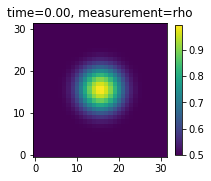

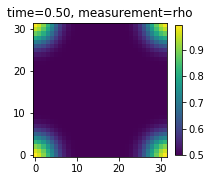

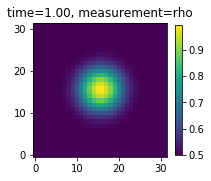

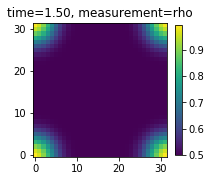

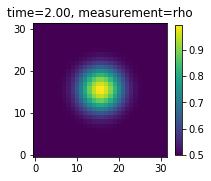

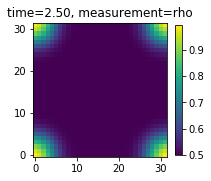

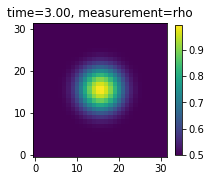

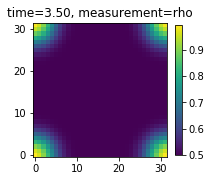

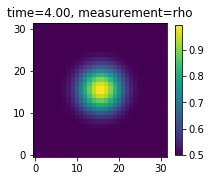

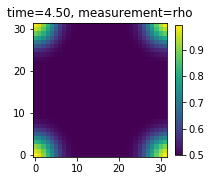

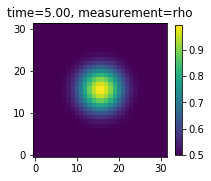

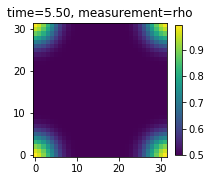

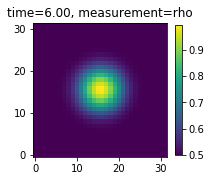

Completed


In [99]:
import scipy.ndimage as sciim
import os

attribute = 'rho'
time = 0
# comp_ref_0 = ensemble_test_case(time, py_path_ref_1,ref_size, attribute,label_type='STEP')
# time = 0.25
# comp_ref_1 = ensemble_test_case(time, py_path_ref_1,ref_size, attribute)

size = 1
grid_x = 32
grid_y = 32
end_time = 6.0
ref_size = size
# suffix = '_truth'
suffix = '_truthgen'

fn = get_filename(grid_x,grid_y,size,end_time,suffix)
print(fn)

path = get_path(fn)
print(path)

fn = get_filename(grid_x,grid_y,size,end_time,'_comp_pp_ref')
py_path_ref_1 = get_path(fn)

fn = get_filename(grid_x,grid_y,size,6.0,'_truthgen')
py_path_ref_2 = get_path(fn)

if os.path.exists(path):
    os.rename(path, path+'_old')
    
file = h5py.File(path, 'a')
attributes = ['rho', 'rhou', 'rhov', 'rhoY', 'Y', 'p2_nodes']
for attr in attributes:
    if not (attr in file):
        file.create_group(attr,track_order=True)
    
file.close()

def roller(arr,n):
    arr = np.roll(arr,n,axis=0)
    arr = np.roll(arr,n,axis=1)
    return arr

# times = np.linspace(0.0,10.0,101*2-1)
# print(times)
# times = [0.0,0.25,0.50,0.75,1.0]
times = np.arange(0.0,6.26,0.005)
steps = range(len(times))
print(steps)
# steps = np.arange(0,321)
# # times = steps / 32
# dt = 1.0 / 32
# times = dt * steps
# print(times)
# print(times)
# print(py_path_ref_1)

# rolled_0 = comp_ref_0.copy()
# rolled_1 = comp_ref_0.copy()

file = h5py.File(path, 'r+')

output_solver = False
print_output = True

# print(py_path_ref_1)
#     print(name)
for attribute in attributes:
    n_step = 0
    comp_ref_0 = ensemble_test_case(0, py_path_ref_1,ref_size, attribute,label_type='TIME')
    rolled_0 = comp_ref_0
    cnt = 0
    
#     name = "ensemble_mem=%i_%.3f_%s" %(0,0,'after_full_step')
#     name = "%.3d_%s" %(0,'after_full_step')
#     file.create_dataset("%s/%s_%s" %(attribute,attribute,name), data=rolled_0, chunks=True, compression='gzip', compression_opts=4, dtype=np.float32)
    for n in steps[:-1]:
        comp_ref_0 = ensemble_test_case(0, py_path_ref_1,ref_size, attribute,label_type='TIME')
        rolled_0 = comp_ref_0
        time = times[cnt]
        name = "ensemble_mem=%i_%.3f_%s" %(0,time,'after_full_step')
#         print(name)
#         name = "%.3d_%s" %(n+1,'after_full_step')
#         print(name)
#         n_step = 65./4 if attribute == 'p2_nodes' else (16.0)
#         n_step = int(n*8.0)
        n_step += (grid_x+1.)/200 if attribute == 'p2_nodes' else (float(grid_x)/200)
        rolled_0 = rolled_0[2:-2,2:-2]
        rolled_0 = np.pad(rolled_0,(1,0),mode='wrap')
        rolled_0 = sciim.shift(rolled_0,n_step, mode='wrap',order=5, prefilter=True)
        rolled_0 = rolled_0[1:,1:]
#         rolled_0 = roller(comp_ref_0[2:-2,2:-2],n_step)
#         rolled_0 = sciim.shift(comp_ref_0[2:-2,2:-2],n_step, mode='wrap')
        rolled_0 = np.pad(rolled_0,2,mode='wrap')
        
        if output_solver == True:
            comp_ref_1 = ensemble_test_case(time, py_path_ref_2,ref_size, attribute, label_type='TIME')
        file.create_dataset("%s/%s_%s" %(attribute,attribute,name), data=rolled_0, chunks=True, compression='gzip', compression_opts=4, dtype=np.float32)
    
# rolled = np.pad(rolled,2,mode='wrap')
        if print_output == True and attribute == 'rho' and n%100==0:
            if output_solver == True:
                fig, ax = plt.subplots(ncols=3, figsize=(9,3))

                ax[0].imshow(comp_ref_1[2:-2,2:-2], origin='lower')
                ax[0].set_title("solver sol.")
                ax[1].imshow(rolled_0[2:-2,2:-2], origin='lower')
                ax[1].set_title("translated sol.")
                im2 = ax[2].imshow(comp_ref_1 - rolled_0, origin='lower')
                ax[2].set_title("difference")
    #             fig.colorbar(im2,ax=ax[2],shrink=0.4)
                fig.colorbar(im2, ax=ax, shrink=.75)
                fig.suptitle("time=%.2f, measurement=%s" %(time,attribute))
                plt.savefig("../output_images/%s_%03d" %(attribute,cnt), bbox_inches='tight')
                plt.show()
            else:
                fig = plt.figure(figsize=(3,3))
                plt.imshow(rolled_0[2:-2,2:-2], origin="lower")
                plt.title("time=%.2f, measurement=%s" %(time,attribute))
                plt.colorbar(shrink=.8)
                plt.show()
                
        cnt += 1
    
file.close()
print("Completed")

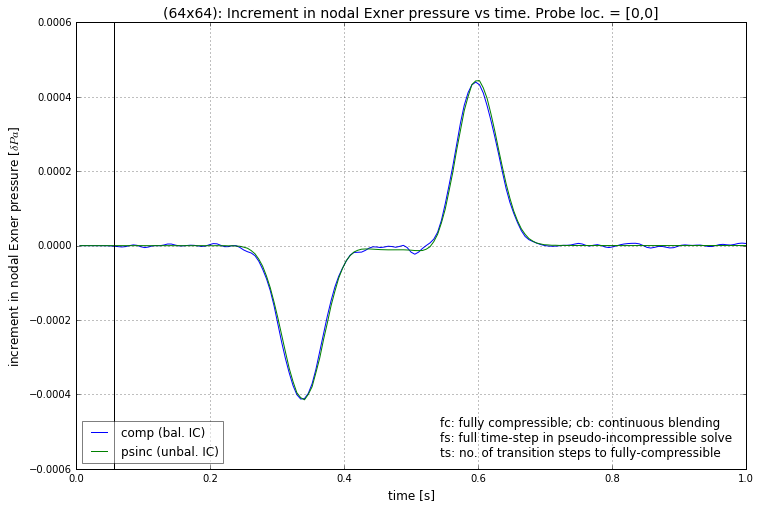

In [501]:
grid_x = 64
grid_y = 64
ens_size = 1
end_time = 1.0
attribute = 'p2_nodes'

time = 1.0
time = 1

def get_arr(time, attribute, suffix, cont_blend=False, ts=0, fs=0, end_time=end_time):
    if len(suffix) > 0:
        suffix = '_' + suffix
    
    if cont_blend == True:
        suffix += '_cont_blend_fs=%i_ts=%i' %(fs,ts)
        
    fn = get_filename(grid_x, grid_y, ens_size, end_time, suffix)
    path = get_path(fn)
    
    return ensemble_test_case(time, path, ens_size, attribute, label_type='STEP')

Ns = 176
# times = np.linspace(0,1.0,num=21)
# times = np.arange(0,174,5)
# times_axis = np.linspace(0,1.0,num=174/5+1)
times = np.arange(0,Ns+1)
# times = times[70:120]
# times = times[160:200]
# times = times[10:]
dt = end_time / Ns
# times_axis = np.linspace(0,end_time,num=Ns)
times_axis = times * dt

# times = times[::2]
# times_axis = times_axis[::2]
# print(times_axis)

def get_diff(probe):
    probe = np.array(probe)
    return probe[1:] - probe[:-1]
#     return probe[:-1]


probe_row = 0
probe_col = 0
attribute = 'p2_nodes'
cb1, cb1_suffix = [1,0], ''
cb2, cb2_suffix = [10,0], ''
cb3, cb3_suffix = [1,0], 'nocorrection'

def get_time_series(times, attribute, suffix, cont_blend=False, ts=0, fs=0, end_time=end_time):
    probe = []
    for time in times:
        arr = get_arr(time, attribute, suffix, cont_blend, ts, fs, end_time=end_time)
        probe.append(arr[probe_row,probe_col])
        
    probe = np.array(probe)
    
    return get_diff(probe)
    
probe = get_time_series(times,attribute,"truth")
probe_fc = get_time_series(times,attribute,"comp")
probe_psinc = get_time_series(times,attribute,"psinc")
# probe_psinc = get_time_series(times,attribute,"_psinc_full_corrections")
# probe_psinc = get_time_series(times,attribute,"_psinc_nocorrection")
# probe_cb1 = get_time_series(times,attribute,cb1_suffix,cont_blend=True,fs=cb1[0],ts=cb1[1])
# probe_cb2 = get_time_series(times,attribute,cb2_suffix,cont_blend=True,fs=cb2[0],ts=cb2[1])
# probe_cb3 = get_time_series(times,attribute,cb3_suffix,cont_blend=True,fs=cb3[0],ts=cb3[1])

fig1 = plt.figure(figsize=(12,8))
plt.plot(times_axis[1:],probe, label='comp (bal. IC)')
# plt.plot(times_axis[1:],probe_fc, '--', label='comp (unbal. IC)')
plt.plot(times_axis[1:],probe_psinc, '-', label='psinc (unbal. IC)')
# plt.plot(times_axis[1:],probe_cb1, '-', label='cb: fs=%i, ts=%i' %(cb1[0],cb1[1]))
# plt.plot(times_axis[1:],probe_cb2, '--', label='cb: fs=%i, ts=%i' %(cb2[0],cb2[1]))
# plt.plot(times_axis[1:],probe_cb3, '-', label='cb: fs=%i, ts=%i, %s' %(cb3[0],cb3[1],cb3_suffix))

plt.axvline(times_axis[1:][9], c='k')
# plt.axvline(times_axis[1:][20])
# plt.axvline(3.0)
plt.ylabel('increment in nodal Exner pressure [$\delta Pa$]', fontsize='12')
plt.xlabel('time [s]', fontsize='12')
plt.title("(%ix%i): Increment in nodal Exner pressure vs time. Probe loc. = [%i,%i]" %(grid_x,grid_y,probe_row,probe_col), fontsize='14')
txt = '''
        fc: fully compressible; cb: continuous blending
        fs: full time-step in pseudo-incompressible solve
        ts: no. of transition steps to fully-compressible
        '''
fig1.text(.51,.12,txt,fontsize='12')
plt.xlim([times_axis[0],times_axis[-1]])
plt.legend(loc='lower left', framealpha=0.5)
plt.grid()
plt.show()

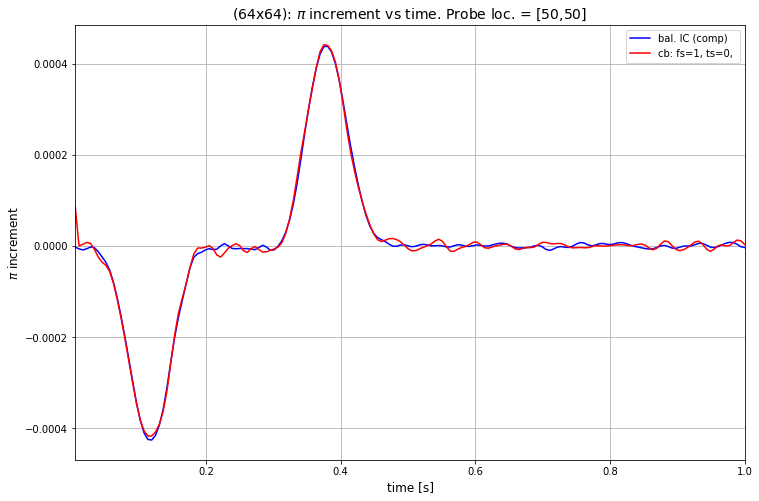

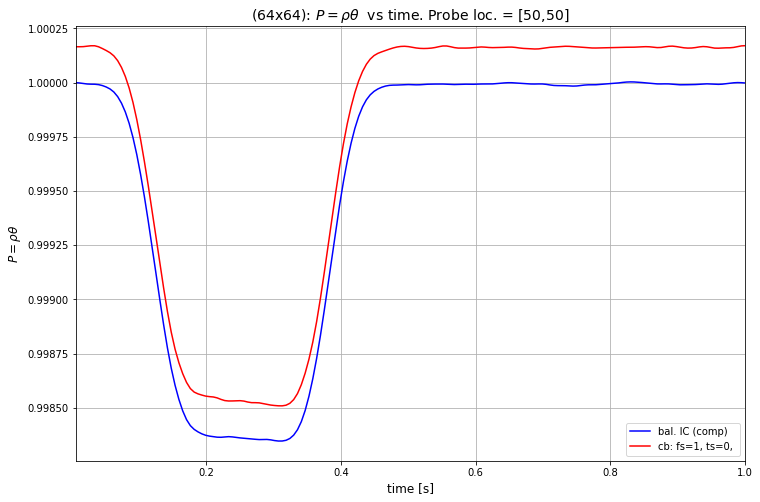

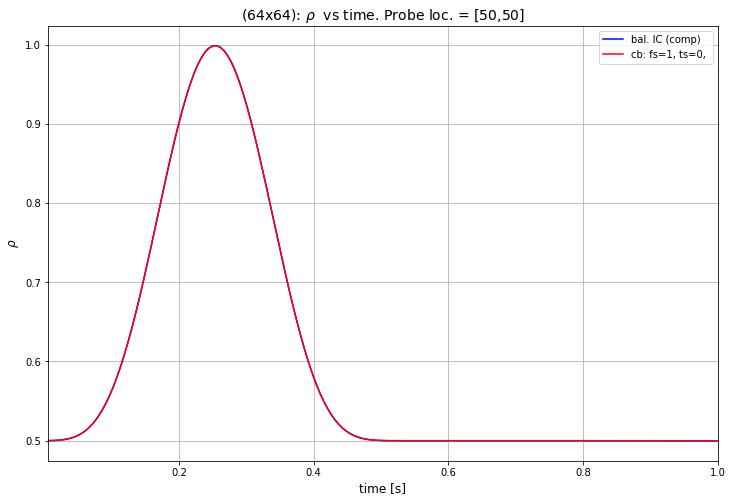

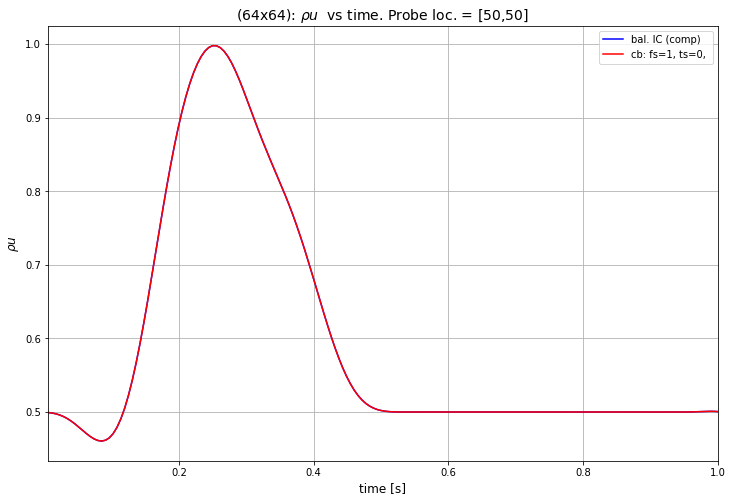

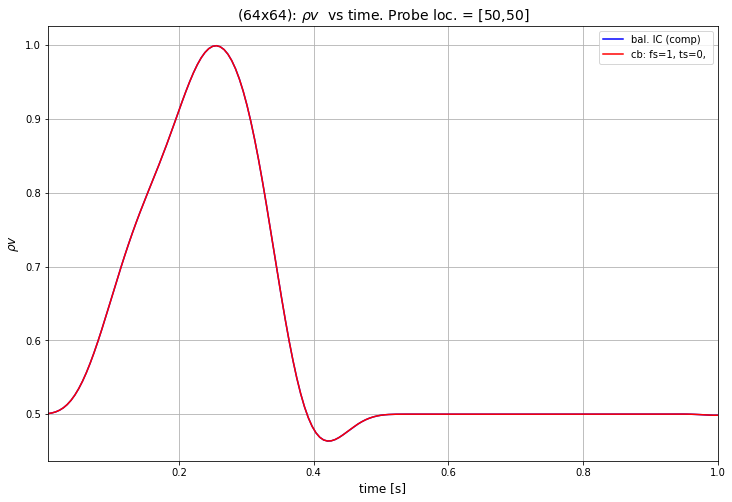

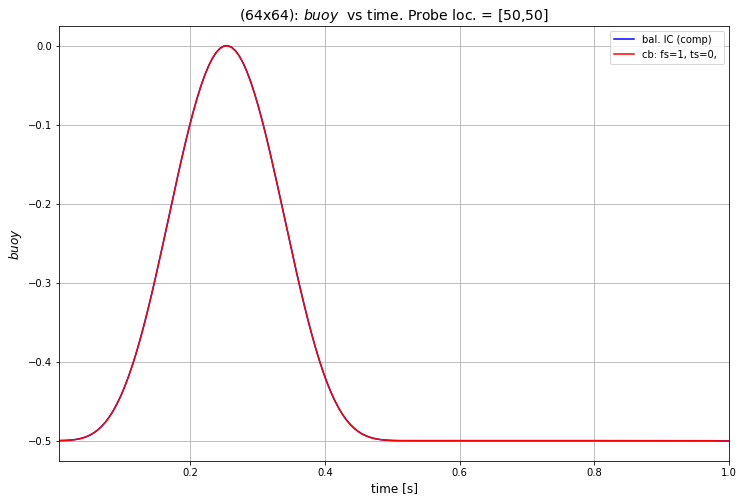

In [295]:
grid_x = 64
grid_y = 64
ens_size = 1
end_time = 1.0
attribute = 'p2_nodes'

time = 1.0
time = 1

def get_arr(time, attribute, suffix, tag, cont_blend=False, ts=0, fs=0, end_time=end_time):
    if cont_blend == True:
        suffix += '_cont_blend_fs=%i_ts=%i' %(fs,ts)
        
    fn = get_filename(grid_x, grid_y, ens_size, end_time, suffix)
    path = get_path(fn)
    
    return ensemble_test_case(time, path, ens_size, attribute, tag=tag, label_type='STEP')

Ns = 176
Ns_full = 176
# Ns = 199
# Ns_full = 199
# Ns, Ns_full = 528, 528
times = np.arange(0,Ns+1)
# times = times[98:115]
# times = times[109:116]
# times = times[94:101]
# times = times[70:100]
# times = times[-60:]
# times = times[:50]
dt = end_time / Ns_full
times_axis = times * dt

# times_axis = times_axis[::2]
# print(times_axis)

probe_row = 50
probe_col = 50
attributes = ['p2_nodes', 'rhoY', 'rho', 'rhou', 'rhov', 'buoy']
attributes_str = {
    'p2_nodes': r'$\pi$',
    'rhoY' : r'$P = \rho \theta$',
    'rho' : r'$\rho$',
    'rhou' : r'$\rho u$',
    'rhov' : r'$\rho v$',
    'buoy' : r'$buoy$',
}
cb1, cb1_suffix = [1,0], ''
cb2, cb2_suffix = [10,0], ''
cb3, cb3_suffix = [20,0], ''

# cb1, cb1_suffix = [1,0], '_conversion_1'
# cb2, cb2_suffix = [1,0], '_conversion_2'
# cb3, cb3_suffix = [1,0], '_no_conversion'

cb1, cb1_suffix = [1,0], ''
cb2, cb2_suffix = [1,0], '_method_1'
cb3, cb3_suffix = [1,0], '_method_2'

# cb1, cb1_suffix = [0,5], ''
# cb2, cb2_suffix = [0,10], ''
# cb3, cb3_suffix = [0,20], ''

def get_time_series(times, attribute, suffix, cont_blend=False, ts=0, fs=0, end_time=end_time):
    probe = []
    tag = 'before_flux'
#     tag = 'before_advect'
#     tag = 'after_advect'
#     tag = 'after_ebnaexp'
#     tag = 'after_ebnaimp'
#     
    tag = 'after_half_step'
#     tag = 'after_efna'
#     tag = 'after_full_ebnaexp'
    tag = 'after_full_step'
    
    for time in times:
        arr = get_arr(time, attribute, suffix, tag, cont_blend, ts, fs, end_time=end_time)
        
#         arr -= arr.mean()
        probe.append(arr[probe_row,probe_col])
        
    probe = np.array(probe)
    
    if attribute == 'p2_nodes' and increment == True:
        probe = np.diff(probe)
    return probe
    
# times_axis = times#np.arange(0,Ns+1)

increment = True
for attribute in attributes:
    if attribute == 'p2_nodes' and increment == True:
        t_axs = times_axis[1:]
        inc = "increment" if increment == True else ""
    else:
        t_axs = times_axis
        inc = ""
        
#     probe = get_time_series(times,attribute,"_truth")
#     probe_th = get_time_series(times,attribute,"_truth_half_two")
    probe_fc = get_time_series(times,attribute,"_comp")
#     probe_fc = get_time_series(times,attribute,"_hypo")
#     probe_psinc = get_time_series(times,attribute,"_psinc")

#     probe_th = np.diff(probe_psinc)
#     probe_th = (probe_psinc[1:] + probe_psinc[:-1]) * 0.5
    probe_cb1 = get_time_series(times,attribute,cb1_suffix,cont_blend=True,fs=cb1[0],ts=cb1[1])
#     probe_cb2 = get_time_series(times,attribute,cb2_suffix,cont_blend=True,fs=cb2[0],ts=cb2[1])
#     probe_cb3 = get_time_series(times,attribute,cb3_suffix,cont_blend=True,fs=cb3[0],ts=cb3[1])

    fig1 = plt.figure(figsize=(12,8))
#     plt.plot(t_axs,probe, '-', label='bal. IC (comp)', c='b')
#     plt.plot(t_axs-1.0+1./16,probe_th, '-', label='bal. IC', c='k')
#     probe_psinc = (3.0 * probe_psinc[:-1] + probe_psinc[1:]) / 4.0
    plt.plot(t_axs,probe_fc, '-', label='bal. IC (comp)', c='b')
#     plt.plot(t_axs,probe_psinc, '-', label='imbal. IC (psinc)', c='g')
#     cb1_suffix = ' "1/4 + 3/4" strategy for $\pi$ conversion'
    plt.plot(t_axs,probe_cb1, '-', label='cb: fs=%i, ts=%i, %s' %(cb1[0],cb1[1], cb1_suffix[1:]), c='r')
#     cb2_suffix = ' $\pi$ taken at half time-step for conversion'
#     plt.plot(t_axs,probe_cb2, '-', label='cb: fs=%i, ts=%i, %s' %(cb2[0],cb2[1], cb2_suffix[1:]), c='y')
#     cb3_suffix = ' 1/16 time-step offset for $\pi$ conversion'
#     plt.plot(t_axs,probe_cb3, '-', label='cb: fs=%i, ts=%i, %s' %(cb3[0],cb3[1], cb3_suffix[1:]), c='k')

#     plt.axvline(times_axis[1:][1], c='k')
#     plt.axvline(times_axis[1:][5], c='k')
#     plt.axvline(times_axis[1:][5], c='k')
#     plt.axvline(111.5, ls='--', c='k')
    
#     plt.axvline(112.0+0.25, ls='--', c='g', label='timelongstep = 112.25')
#     plt.axvline(112.5, ls='--', c='b', label='timestep = 112.50')
#     plt.axvline(113.0-0.125/2, ls='--', c='k')
    
#     plt.axvline(112.75, ls='--', c='k')
#     plt.axvline(98.5, ls='--', c='k')
#     plt.axvline(98.25, ls='--', c='k')
#     plt.axvline(98.0, ls='--', c='k')
#     plt.axhline(1.9906298e-04, ls='--', c='k')
#     plt.axhline(1.6641221e-04, ls='--', c='k')
    
    
#     plt.axhline(1.9906298e-04, ls='--', c='k', label='bal. IC at time step = 112')
#     plt.axhline(1.61960255e-04, ls='--', c='k')
    
    plt.ylabel('%s %s' %(attributes_str[attribute],inc), fontsize='12')
    plt.xlabel('time [s]', fontsize='12')
#     plt.xlabel('number of time steps', fontsize='12')
    
    plt.title("(%ix%i): %s %s vs time. Probe loc. = [%i,%i]" %(grid_x,grid_y,attributes_str[attribute],inc,probe_row,probe_col), fontsize='14')
    txt =   '''
            fc: fully compressible; cb: continuous blending
            fs: full time-step in pseudo-incompressible solve
            ts: no. of transition steps to fully-compressible
            '''
#     fig1.text(.50,.12,txt,fontsize='12')
    plt.ticklabel_format(axis='x', useOffset=False)
    plt.xlim([times_axis[1],times_axis[-1]])
    plt.legend(loc='best')
    plt.grid()
    plt.savefig('%s.pdf' %attribute, bbox_inches='tight')
    plt.show()

In [299]:
attribute = 'p2_nodes'
times = np.arange(40)
def get_time_series(times, attribute, suffix, cont_blend=False, ts=0, fs=0, end_time=end_time):
    tag = 'ic'
    tag = 'after_full_step'
    probe = []
    for time in times:
        arr = get_arr(time, attribute, suffix, tag, cont_blend, ts, fs, end_time=end_time)
        probe.append(arr)
        
    return np.array(probe)
    
truth = get_time_series(times,attribute,"_truth")
truth_c = get_time_series(times,attribute,"_truth_corrected")
comp = get_time_series(times,attribute,"_comp")
psinc = get_time_series(times,attribute,"_psinc")
cb1_arr = get_time_series(times,attribute,"",cont_blend=True,fs=cb1[0],ts=cb1[1])
cb2_arr = get_time_series(times,attribute,"",cont_blend=True,fs=cb2[0],ts=cb2[1])


sfactor = 1.0
# for i in range(80):
cnt = 0

truth0 = np.copy(truth)
truth = truth[1:] - truth[:-1]
truth_c = truth_c[1:] - truth_c[:-1]
comp0 = np.copy(comp)
comp = comp[1:] - comp[:-1]
psinc0 = np.copy(psinc)
psinc = psinc[1:] - psinc[:-1]
cb1_arr = cb1_arr[1:] - cb1_arr[:-1]
cb2_arr = cb2_arr[1:] - cb2_arr[:-1]
# print(psinc.shape)
# diff = (psinc0[1:] * 0./4 + psinc0[:-1] * 4./4) - comp0[:-1]

# truth1 = truth0[:]-truth0.mean(axis=(1,2))[:,None,None]
# psinc1 = psinc0[:]-psinc0.mean(axis=(1,2))[:,None,None]

# diff = np.diff(psinc0) - np.diff(truth0)
diff = psinc1 - truth1
# diff -= diff.mean()
# diff = np.diff(diff)
# diff1 = (psinc0[1:] * 0.5 + psinc0[:-1] * 0.5) - comp0[:-1]
# diff1 -= diff1.mean()
# diff = psinc0 * 3./4 + comp0 * 1./4 - comp0

for i in range(38,len(times)):
    fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(18,9))
    im0 = ax[0,0].imshow(truth[i], origin="lower")
    ax[0,0].set_title("comp w. bal. IC (p2n increment)")
    fig.colorbar(im0,ax=ax[0,0],shrink=sfactor)
    
    im1 = ax[0,1].imshow(comp[i], origin="lower")
    ax[0,1].set_title("comp w. unbal. IC (p2n icrement)")
    fig.colorbar(im1,ax=ax[0,1],shrink=sfactor)
    
    im2 = ax[0,2].imshow(psinc[i], origin="lower")
    ax[0,2].set_title("psinc w. unbal IC (p2n increment)")
    fig.colorbar(im2,ax=ax[0,2],shrink=sfactor)
    
#     im2a = ax[1,0].imshow(truth_c[i] - psinc[i], origin="lower")
#     ax[1,0].set_title("truth corr - psinc. p2n")
#     fig.colorbar(im2a,ax=ax[1,0],shrink=sfactor)
    
#     im3 = ax[1,1].imshow(cb1_arr[i], origin="lower")
#     ax[1,1].set_title("cb1 p2i,fs/ts=%i/%i" %(cb1[0],cb1[1]))
#     fig.colorbar(im2,ax=ax[1,1],shrink=sfactor)
    
#     im3a = ax[1,2].imshow(cb2_arr[i], origin="lower")
#     ax[1,2].set_title("cb2 p2i,fs/ts=%i/%i" %(cb2[0],cb2[1]))
#     fig.colorbar(im3a,ax=ax[1,2],shrink=sfactor)
    
    im3 = ax[1,0].imshow(truth0[i], origin="lower")
    ax[1,0].set_title("comp w. bal. IC (p2n)")
    fig.colorbar(im3,ax=ax[1,0],shrink=sfactor)

    im4a = ax[1,1].imshow(comp0[i], origin="lower")
    fig.colorbar(im4a,ax=ax[1,1],shrink=sfactor)
    ax[1,1].set_title("comp w. unbal. IC (p2n)")
    
    im4 = ax[1,2].imshow(psinc0[i], origin="lower")
    fig.colorbar(im4,ax=ax[1,2],shrink=sfactor)
    ax[1,2].set_title("psinc w. unbal. IC (p2n)")
    
#     im5 = ax[0,2].imshow(diff[i] , origin="lower")
#     fig.colorbar(im5,ax=ax[0,2],shrink=sfactor)
#     ax[0,2].set_title("Truth PI diff")
    
#     psincm = psinc0[i] - psinc0[i].mean()
#     im6 = ax[1,2].imshow(psincm - psincm.max() , origin="lower")
#     fig.colorbar(im6,ax=ax[1,2],shrink=sfactor)
#     ax[1,2].set_title("diff + psinc")
    
#     fig.delaxes(ax[1,2])
    fig.suptitle(r'Time step=(%.3d-%.3d), time=%.3f for quantity %s' %(i+1,i,times_axis[i],attribute), fontsize='16')

    plt.savefig("../output_images/%s_%03d" %(attribute,cnt), bbox_inches='tight')
    plt.close()
    cnt += 1
#     plt.gca.clear()

KeyError: "Unable to open object (object 'p2_nodes_ensemble_mem=0_0.000_after_full_step' doesn't exist)"

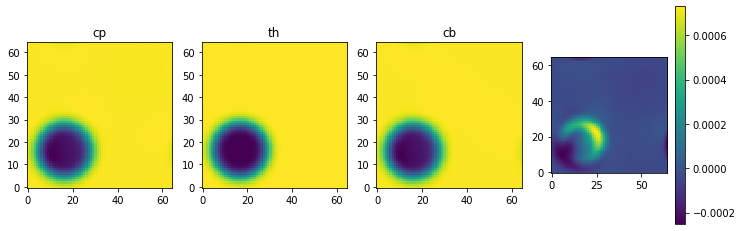

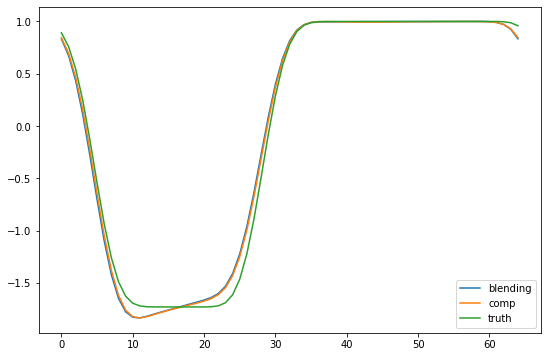

In [334]:
grid_x = 64
grid_y = 64
ens_size = 1
end_time = 1.0
attribute = 'p2_nodes'

time = 1.0
time = 1

def get_arr(time, attribute, suffix, tag, cont_blend=False, ts=0, fs=0, end_time=end_time):
    if cont_blend == True:
        suffix += '_cont_blend_fs=%i_ts=%i' %(fs,ts)
        
    fn = get_filename(grid_x, grid_y, ens_size, end_time, suffix)
    path = get_path(fn)
    
    return ensemble_test_case(time, path, ens_size, attribute, tag=tag, label_type='TIME')

Ns = 199
Ns_full = 199
times_full = np.arange(0,Ns+1)
# times = np.array([1,51,101,151])
# times = times[:2]
times = np.arange(0.0,1.001,0.005)
dt = end_time / Ns_full
times_axis = times * dt

attributes = ['p2_nodes', 'rhoY', 'rho', 'rhou', 'rhov', 'buoy']
# attributes = ['dp2n', 'p2_start', 'p2_end']
attributes_str = {
    'p2_nodes': r'$\pi$',
    'rhoY' : r'$P = \rho \theta$',
    'rho' : r'$\rho$',
    'rhou' : r'$\rho u$',
    'rhov' : r'$\rho v$',
    'buoy' : r'$buoy$',
    'p2_start' : 'p2_start',
    'p2_end' : 'p2_end',
    'dp2n' : 'dp2n'
}

cb1, cb1_suffix = [1,0], ''

def get_time_series(times, attribute, suffix, cont_blend=False, ts=0, fs=0, end_time=end_time):
    probe = []
    tag = 'before_flux'
#     tag = 'before_advect'
#     tag = 'after_advect'
#     tag = 'after_ebnaexp'
#     tag = 'after_ebnaimp'
#     
    tag = 'after_half_step'
#     tag = 'after_efna'
#     tag = 'after_full_ebnaexp'
    tag = 'after_full_step'

    for time in times:
        arr = get_arr(time, attribute, suffix, tag, cont_blend, ts, fs, end_time=end_time)
        probe.append(arr)
        
    probe = np.array(probe)
    
    if attribute == 'p2_nodes' and increment == True:
        probe = np.diff(probe,axis=0)
    return probe
    
# times_axis = times#np.arange(0,Ns+1)
lst = []
increment = False
for attribute in attributes:
    if attribute == 'p2_nodes' and increment == True:
        t_axs = times_axis[1:]
        inc = "increment" if increment == True else ""
    else:
        t_axs = times_axis
        inc = ""

    probe_cb1 = get_time_series(times,attribute,cb1_suffix,cont_blend=True,fs=cb1[0],ts=cb1[1])
#     probe_cb1 = get_time_series(times,attribute,'_comp')
    lst.append(probe_cb1)

#     cnt = 0
#     fig1, ax = plt.subplots(ncols=4, figsize=(12,6))
#     for time in times:
#         ax[cnt].imshow(probe_cb1[cnt], origin='lower',aspect='equal')
#         ax[cnt].set_title("time %.3f" %(times_axis[cnt]))
        
#         cnt+=1
#     plt.suptitle("%s" %attribute, y=0.75)
#     plt.show()

starts = lst[1]
ends = lst[2]
    
attributes = ['p2_nodes']
times_full = np.arange(0,Ns+1)
times_full = np.arange(0.0,1.001,0.005)
for attribute in attributes:
    if attribute == 'p2_nodes' and increment == True:
        t_axs = times_axis[1:]
        inc = "increment" if increment == True else ""
    else:
        t_axs = times_axis
        inc = ""

    probe_truth = get_time_series(times_full,attribute,'_truthgen')
    probe_cb1 = get_time_series(times_full,attribute,cb1_suffix,cont_blend=True,fs=cb1[0],ts=cb1[1])
#     ptobe_cb1 = get_time_series(times_full,attribute,'_comp')
    probe_comp = get_time_series(times_full,attribute,'_comp')
    
cb1 = np.diff(probe_cb1,axis=0)
comp = np.diff(probe_comp,axis=0)

# cnt = 0
# for cnt in range(cb1.shape[0]):
# #     if cnt in times:
#     plt.figure()
#     plt.imshow(cb1[cnt], origin='lower')
#     plt.colorbar()
#     plt.savefig('../output_images/p2_diff/%.3d.png' %cnt)
# #         plt.show()
#     cnt += 1
#     plt.close()

# for time in times_full:
#     fig, ax = plt.subplots(ncols=3, figsize=(12,8))
# #     ax[0].imshow(probe_comp[time], origin='lower')
# #     ax[1].imshow(probe_cb1[time], origin='lower')
# #     im2, ax[2].imshow(probe_cb1[time] - probe_comp[time])
#     ax[0].imshow(comp[time], origin='lower')
#     ax[1].imshow(cb1[time], origin='lower')
#     im2, ax[2].imshow(cb1[time] - comp[time], origin='lower')
#     plt.colorbar(im2, ax=ax[2], shrink=.3)
#     plt.suptitle("%.3f" %times_axis[cnt])
#     plt.show()
    
import scipy.ndimage as sciim

idx0 = 150
idx1 = 150
idx2 = 150
inner = (slice(2,-2),slice(2,-2))
fig,ax=plt.subplots(ncols=4, figsize=(12,8))
cb = probe_cb1[idx0][inner]
cb -= cb.mean()
cp = probe_comp[idx1][inner]
cp -= cp.mean()
th = probe_truth[idx2][inner]
th -= th.mean()
# cb = sciim.shift(cb, 3./16, mode='wrap')
# th = sciim.shift(th, -4./16, mode='wrap')
im0 = ax[0].imshow(cp, origin='lower')
ax[0].set_title("cp")

# im1 = ax[1].imshow(cp, origin='lower')
# ax[1].set_title("cp")
# im2 = ax[2].imshow(cb - cp, origin='lower')
# plt.colorbar(im2, ax=ax[2], shrink=.5)

im1 = ax[1].imshow(th, origin='lower')
ax[1].set_title("th")

im2 = ax[2].imshow(cb, origin='lower')
ax[2].set_title("cb")

im3 = ax[3].imshow(cp - th, origin='lower')
plt.colorbar(im3, ax=ax[3], shrink=.5)

plt.show()

idx = 15
slc = slice(35,45)
slc = slice(None,)
plt.figure(figsize=(9,6))
cbp =cb[idx]-cb[idx].mean()
cbp /= cbp.max()
cpp = cp[idx] - cp[idx].mean()
cpp /= cpp.max()
# cbp = sciim.shift(cbp,-1./16)

thp = th[idx] - th[idx].mean()
thp /= thp.max()
# thp = sciim.shift(thp,-4./16)

plt.plot(cbp[slc], '-', label='blending')
plt.plot(cpp[slc], '-', label='comp')
plt.plot(thp[slc], '-', label='truth')
# plt.plot(cbp - cpp, label='diff')
plt.legend()
plt.show()

# cnt = 0
# m1 = np.array([probe_cb1[cnt] for cnt in times])
# for time in times:
#     fig, ax = plt.subplots(ncols=3, figsize=(12,8))
#     diffs = (0.0 * ends[cnt] + 4.0 * starts[cnt]) / 4.0
    
# #     diffs = (diffs - diffs.mean()) - (m1[cnt] - m1[cnt].mean())
# #     diffs = m1[0] #- m1[0]
#     print(time)
#     diffs0 = probe_comp[time]
#     im0 = ax[0].imshow(diffs, origin='lower')
#     plt.colorbar(im0, ax=ax[0], shrink=.3)
#     ax[0].set_title("blend, %.3f" %times_axis[cnt])
    
#     im1 = ax[1].imshow(diffs0, origin='lower')
#     plt.colorbar(im1, ax=ax[1], shrink=.3)
#     ax[1].set_title("comp, %.3f" %times_axis[cnt])
    
#     im2 = ax[2].imshow(diffs0 - diffs, origin='lower')
#     plt.colorbar(im2, ax=ax[2], shrink=.3)
#     ax[2].set_title("comp, %.3f" %times_axis[cnt])
#     plt.show()
#     cnt += 1

[[ 26.729223 -31.402828  26.760815]
 [-31.402832 684.7656   -31.402832]
 [ 26.760815 -31.402828  26.729223]]
(slice(17, 20, None), slice(17, 20, None))


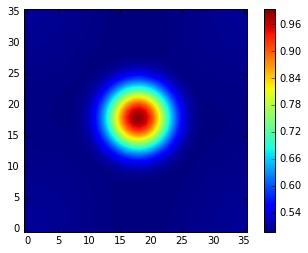

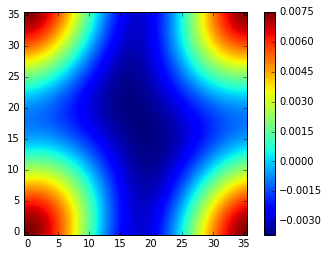

In [441]:
grid_x = 32
grid_y = 32
size = 1
ref_size = 1
end_time = 1.0
fn = get_filename(grid_x,grid_y,size,end_time,'_truth')
py_path_ref_1 = get_path(fn)

attribute = 'rho'
comp_ref_0 = ensemble_test_case(0, py_path_ref_1,ref_size, attribute,label_type='STEP')

arr = np.fft.fft2(comp_ref_0)
arr00 = np.copy(arr[0,0])

arr = np.fft.fftshift(arr)

print(arr[17:20,17:20].real)

slc = (slice(18-1,18+2),slice(18-1,18+2))
print(slc)
arr[17:20,17:20] += 3.0 * np.random.random(arr[17:20,17:20].shape)
arr = np.fft.ifftshift(arr)
arr[0,0] = arr00
arr = np.fft.ifft2(arr).real

fig = plt.figure()
plt.imshow(arr.real, origin='lower')
plt.colorbar()
plt.show()

fig = plt.figure()
plt.imshow(arr - comp_ref_0, origin='lower')
plt.colorbar()
plt.show()

